Import & Device Setup

In [1]:
import os
import torch
import numpy as np
import random
import keras
import shutil
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"📦 Using device: {device}")

2025-09-29 08:32:23.365623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759134743.558521      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759134743.620123      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📦 Using device: cuda


In [2]:
import os
import shutil

# Path sumber data (read-only)
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/'

# Path tujuan yang SPESIFIK di dalam /kaggle/working/
output_path = '/kaggle/working/IMG_CLASSES/'

# 1. Hapus direktori tujuan LAMA jika ada, untuk memastikan kebersihan
if os.path.exists(output_path):
    print(f"Menghapus direktori lama: {output_path}")
    shutil.rmtree(output_path)

# 2. Salin dataset dari input ke direktori tujuan yang baru
print(f"Menyalin dataset ke: {output_path}")
shutil.copytree(data_path, output_path)

print("✅ Dataset berhasil disalin.")

Menyalin dataset ke: /kaggle/working/IMG_CLASSES/
✅ Dataset berhasil disalin.


Class counts: [2103, 3323, 1702, 2079, 3140, 1257, 1847, 2055, 7970, 1677]
Nama Kelas: ['10. Warts Molluscum and other Viral Infections - 2103', '4. Basal Cell Carcinoma (BCC) 3323', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k', '6. Benign Keratosis-like Lesions (BKL) 2624', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '5. Melanocytic Nevi (NV) - 7970', '1. Eczema 1677']
Jumlah Gambar per Kelas: [2103, 3323, 1702, 2079, 3140, 1257, 1847, 2055, 7970, 1677]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


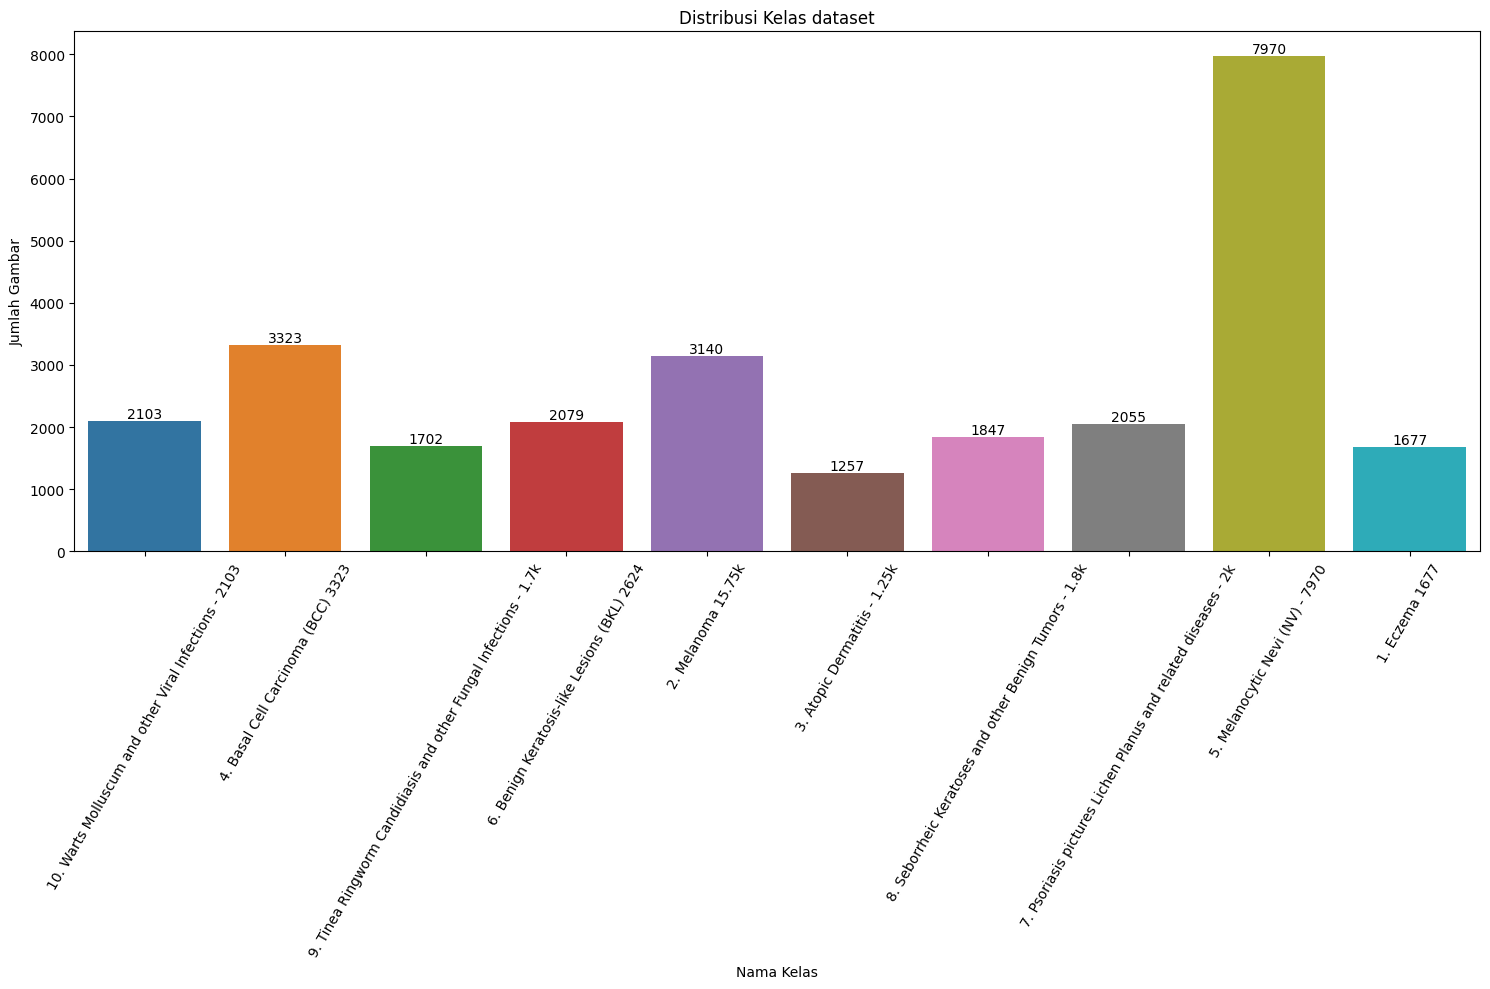

In [3]:
import seaborn  as sns


classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)

print(f"Nama Kelas: {classes}")
print(f"Jumlah Gambar per Kelas: {class_counts}")

# Membuat plot
plt.figure(figsize=(15,10))
ax = sns.barplot(x=classes, y=class_counts)
plt.xticks(rotation=60)
plt.title("Distribusi Kelas dataset")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Nama Kelas")
plt.tight_layout()
for bar in ax.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}', # Gunakan int() agar tidak ada angka desimal
        ha='center',
        va='bottom',
        fontsize=10 
    )
plt.show()

In [4]:
import os
import shutil
import random

# Path ke folder dataset asli Anda yang sudah benar
output_path = '/kaggle/working/IMG_CLASSES/' 

# Path tujuan untuk menyimpan dataset yang sudah di-split
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

for path in [train_path, val_path, test_path]:
    if os.path.exists(path):
        print(f"Menghapus direktori lama: {path}")
        shutil.rmtree(path)

# Buat direktori dataset tujuan
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Definisikan rasio split
train_ratio = 0.8
val_ratio = 0.1

# Lakukan proses split untuk setiap kelas
for class_folder in os.listdir(output_path):
    class_path = os.path.join(output_path, class_folder)
    
    # Pastikan item adalah direktori, bukan file
    if not os.path.isdir(class_path):
        continue

    # Buat sub-folder kelas di direktori train, val, dan test
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # Acak semua gambar di dalam folder kelas
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    
    # Hitung jumlah gambar untuk setiap bagian
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    
    # Alokasikan gambar ke setiap bagian
    train_images = images[:num_train]
    val_images = images[num_train : num_train + num_val]
    test_images = images[num_train + num_val:]
    
    # Salin gambar ke direktori yang sesuai
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("✅ Proses pembagian dataset telah selesai.")

✅ Proses pembagian dataset telah selesai.


In [5]:
import os
import pandas as pd

# Path ke direktori yang sudah di-split
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Siapkan list untuk menyimpan hasil
distribution_data = []

# Loop melalui setiap direktori (train, val, test)
for split_name, split_path in [('Train', train_path), ('Validation', val_path), ('Test', test_path)]:
    # Dapatkan daftar nama kelas (sub-folder)
    class_folders = os.listdir(split_path)
    
    for class_folder in class_folders:
        # Hitung jumlah gambar di dalam setiap folder kelas
        num_images = len(os.listdir(os.path.join(split_path, class_folder)))
        
        # Tambahkan informasi ke dalam list
        distribution_data.append({
            'Split': split_name,
            'Kelas': class_folder,
            'Jumlah Gambar': num_images
        })

# Buat DataFrame dari list untuk tampilan yang rapi
df_dist = pd.DataFrame(distribution_data)

# Tampilkan tabel
print("Distribusi Jumlah Gambar per Kelas di Setiap Set:")
print(df_dist.to_string()) # Gunakan to_string() agar semua baris ditampilkan

Distribusi Jumlah Gambar per Kelas di Setiap Set:
         Split                                                             Kelas  Jumlah Gambar
0        Train             10. Warts Molluscum and other Viral Infections - 2103           1682
1        Train                                4. Basal Cell Carcinoma (BCC) 3323           2658
2        Train  9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k           1361
3        Train                       6. Benign Keratosis-like Lesions (BKL) 2624           1663
4        Train                                                2. Melanoma 15.75k           2512
5        Train                                      3. Atopic Dermatitis - 1.25k           1005
6        Train            8. Seborrheic Keratoses and other Benign Tumors - 1.8k           1477
7        Train     7. Psoriasis pictures Lichen Planus and related diseases - 2k           1644
8        Train                                   5. Melanocytic Nevi (NV) - 7970      

Data Transforms

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [7]:
#Buat Dataset untuk setiap bagian
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(val_path, transform=val_transform) # Menggunakan val_path dan val_transform juga untuk test set

# Buat DataLoader untuk setiap dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Dapatkan nama kelas dan cetak ringkasan
class_names = train_dataset.classes
print(f"✅ Berhasil memuat:")
print(f"- {len(train_dataset)} gambar training")
print(f"- {len(val_dataset)} gambar validasi")
print(f"- {len(test_dataset)} gambar test")
print(f"📚 Jumlah kelas: {len(class_names)}")

✅ Berhasil memuat:
- 21719 gambar training
- 2711 gambar validasi
- 2711 gambar test
📚 Jumlah kelas: 10


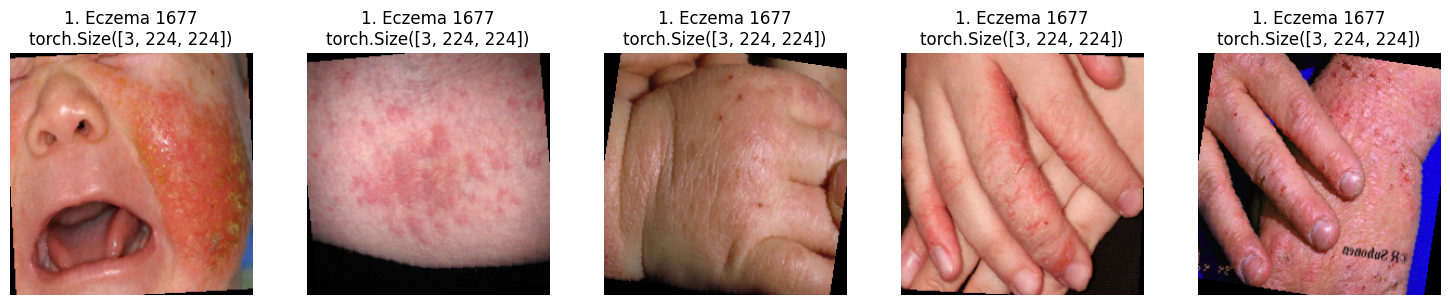

In [11]:
# 2. Visual check of sample images (with titles and shape info)
def visualize_samples(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        image, label = dataset[i]
        img_display = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img_display)
        axes[i].set_title(f"{class_names[label]}\n{image.shape}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

Weighted Loss

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import timm
import time
import copy
import pandas as pd
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pastikan variabel-variabel ini sudah ada dari sel sebelumnya:
# device, train_loader, val_loader, test_loader
# train_dataset, val_dataset, test_dataset, class_weights_tensor, class_names

# ===================================================================
# BARU: Definisikan Model 
# ===================================================================
print("Membuat model MobileNetV4...")
# Dapatkan jumlah kelas dari dataset Anda
num_classes = len(train_dataset.classes)

# Di sini Anda membuat model menggunakan library timm
model = timm.create_model(
    'mobilenetv4_hybrid_medium.e500_r224_in1k', 
    pretrained=True, 
    num_classes=num_classes # Menyesuaikan output dengan jumlah kelas Anda
)
model.to(device) # Pindahkan model ke device
print("✅ Model berhasil dibuat.")

# ===================================================================
# 1. Setup untuk Training
# ===================================================================
# Loss function dengan bobot kelas
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer dan Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

Membuat model MobileNetV4...
✅ Model berhasil dibuat.


Konfigurasi Training

In [24]:
# Konfigurasi training
NUM_EPOCHS = 25 # Tambah epoch karena ada early stopping
PATIENCE = 4      # Jumlah epoch untuk menunggu sebelum early stopping
best_val_acc = 0.0
early_stop_counter = 0
save_path = "best_model.pth"

# Siapkan history untuk plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

In [25]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- Tahap Training ---
    model.train()
    running_train_loss, correct_train_preds = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train_preds += torch.sum(preds == labels.data)
    
    # --- Tahap Validasi ---
    model.eval()
    running_val_loss, correct_val_preds = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val_preds += torch.sum(preds == labels.data)
            
    # Hitung dan simpan loss/akurasi rata-rata
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = correct_train_preds.double() / len(train_dataset)
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = correct_val_preds.double() / len(val_dataset)
    
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())
    
    # Cetak hasil per epoch
    end_time = time.time()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f} | "
          f"Waktu: {end_time - start_time:.2f}s")

    # --- Early Stopping & Model Checkpointing ---
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), save_path)
        print(f"📌 Checkpoint disimpan: Val Acc meningkat ke {best_val_acc:.4f}")
        early_stop_counter = 0 # Reset counter
    else:
        early_stop_counter += 1
        print(f"Val Acc tidak meningkat. Counter: {early_stop_counter}/{PATIENCE}")

    if early_stop_counter >= PATIENCE:
        print("⏹️ Early stopping terpicu.")
        break
        
    # Update learning rate
    scheduler.step(epoch_val_acc)

print("\n🎉 Training selesai!")

Epoch 1/25 | Train Loss: 1.8020 | Train Acc: 0.5247 | Val Loss: 8.0848 | Val Acc: 0.6706 | Waktu: 137.66s
📌 Checkpoint disimpan: Val Acc meningkat ke 0.6706
Epoch 2/25 | Train Loss: 1.0210 | Train Acc: 0.6808 | Val Loss: 418.2052 | Val Acc: 0.7115 | Waktu: 138.25s
📌 Checkpoint disimpan: Val Acc meningkat ke 0.7115
Epoch 3/25 | Train Loss: 0.9188 | Train Acc: 0.7132 | Val Loss: 441.3462 | Val Acc: 0.7329 | Waktu: 138.23s
📌 Checkpoint disimpan: Val Acc meningkat ke 0.7329
Epoch 4/25 | Train Loss: 0.8317 | Train Acc: 0.7440 | Val Loss: 30.8063 | Val Acc: 0.7554 | Waktu: 137.61s
📌 Checkpoint disimpan: Val Acc meningkat ke 0.7554
Epoch 5/25 | Train Loss: 0.7437 | Train Acc: 0.7749 | Val Loss: 10.8452 | Val Acc: 0.7713 | Waktu: 137.34s
📌 Checkpoint disimpan: Val Acc meningkat ke 0.7713
Epoch 6/25 | Train Loss: 0.7919 | Train Acc: 0.7581 | Val Loss: 8.5313 | Val Acc: 0.7352 | Waktu: 139.07s
Val Acc tidak meningkat. Counter: 1/4
Epoch 7/25 | Train Loss: 0.6144 | Train Acc: 0.8149 | Val Loss: 2

✅ Model terbaik dari 'best_model.pth' berhasil dimuat.
🔍 Mengevaluasi model pada Test Set...
✅ Evaluasi selesai.

📊 Classification Report:
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.72      0.82      0.77       167
           10. Warts Molluscum and other Viral Infections - 2103       0.77      0.79      0.78       210
                                              2. Melanoma 15.75k       0.94      1.00      0.97       314
                                    3. Atopic Dermatitis - 1.25k       0.60      0.65      0.62       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.94      0.96      0.95       332
                                 5. Melanocytic Nevi (NV) - 7970       0.98      0.93      0.95       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.80      0.87      0.84       207
   7. Psoria

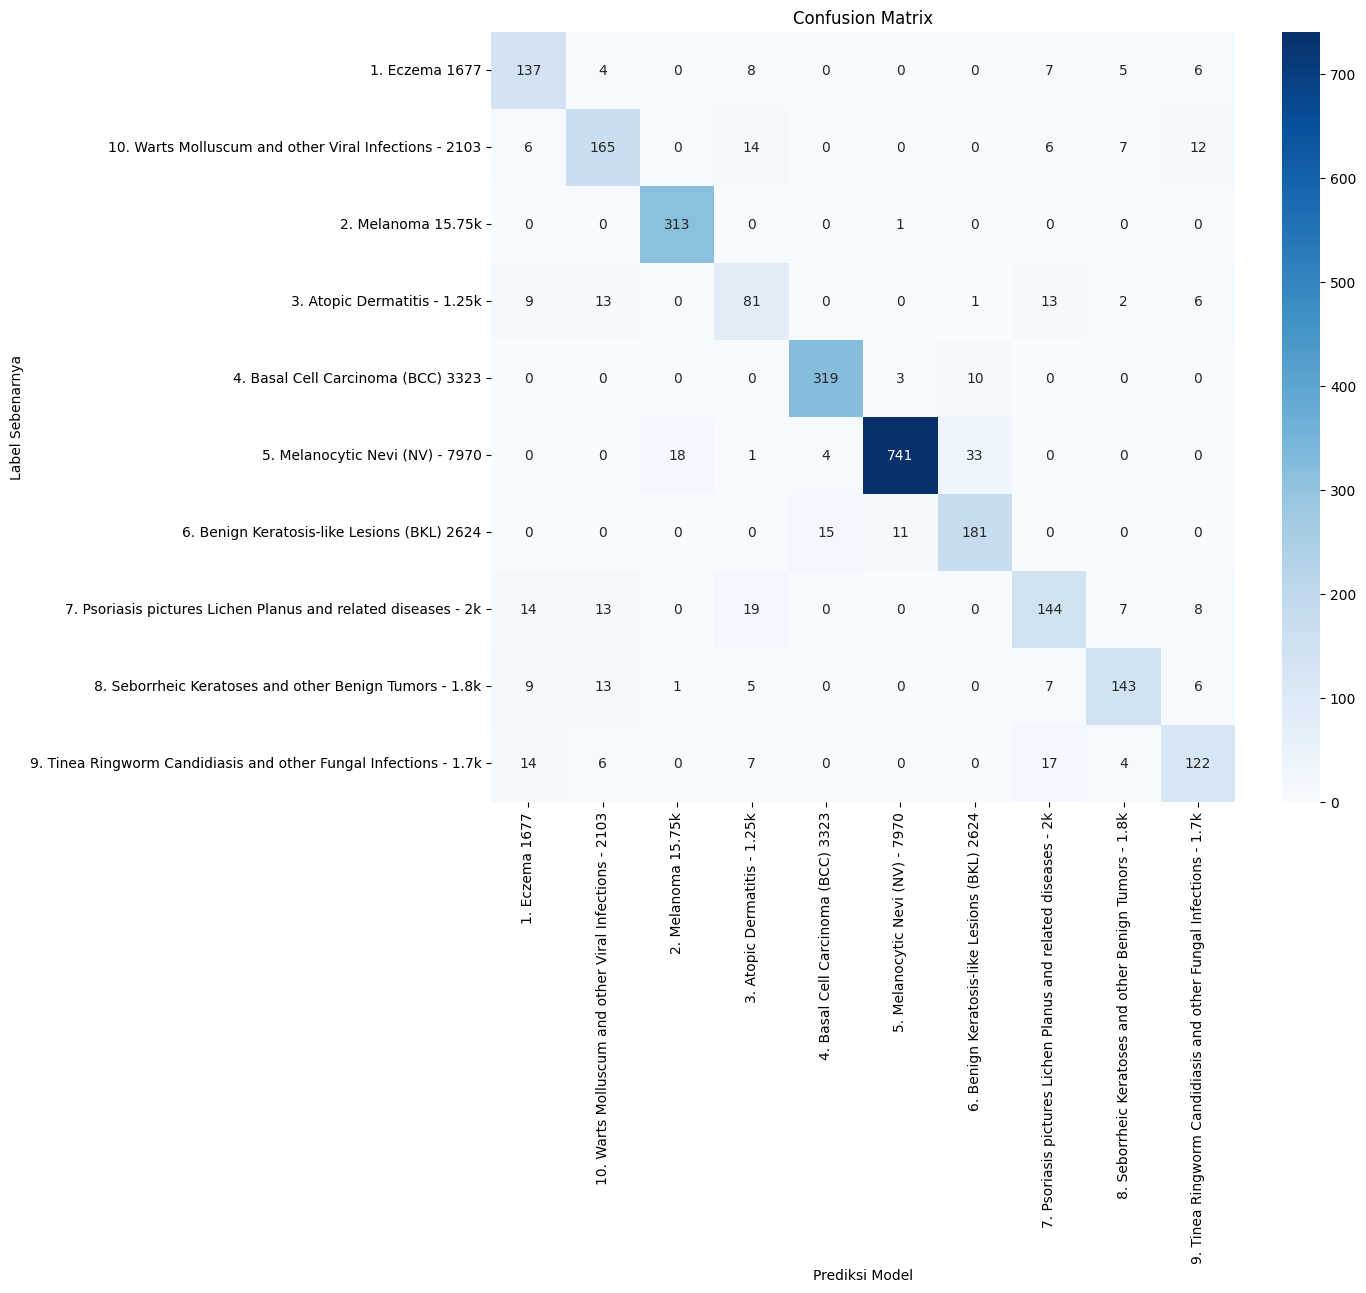

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pastikan variabel ini sudah ada:
# model, device, test_loader, save_path, class_names

# 1. Muat bobot model terbaik yang telah disimpan
model.load_state_dict(torch.load(save_path))
print(f"✅ Model terbaik dari '{save_path}' berhasil dimuat.")

# 2. Lakukan prediksi pada test set
print("🔍 Mengevaluasi model pada Test Set...")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # Pindahkan label ke CPU untuk disimpan di list
        labels = labels.cpu().numpy() 
        
        outputs = model(inputs)
        # Ambil prediksi dengan probabilitas tertinggi
        preds = torch.max(outputs, 1)[1]
        preds = preds.cpu().numpy()
        
        y_pred.extend(preds)
        y_true.extend(labels)

print("✅ Evaluasi selesai.")

# 3. Tampilkan Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# 4. Tampilkan Confusion Matrix
print("\n📈 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

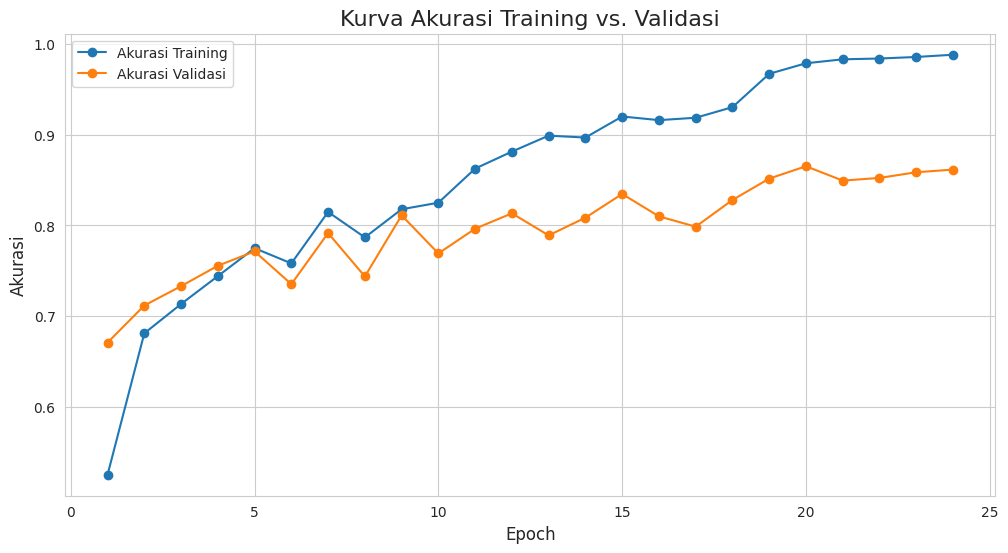

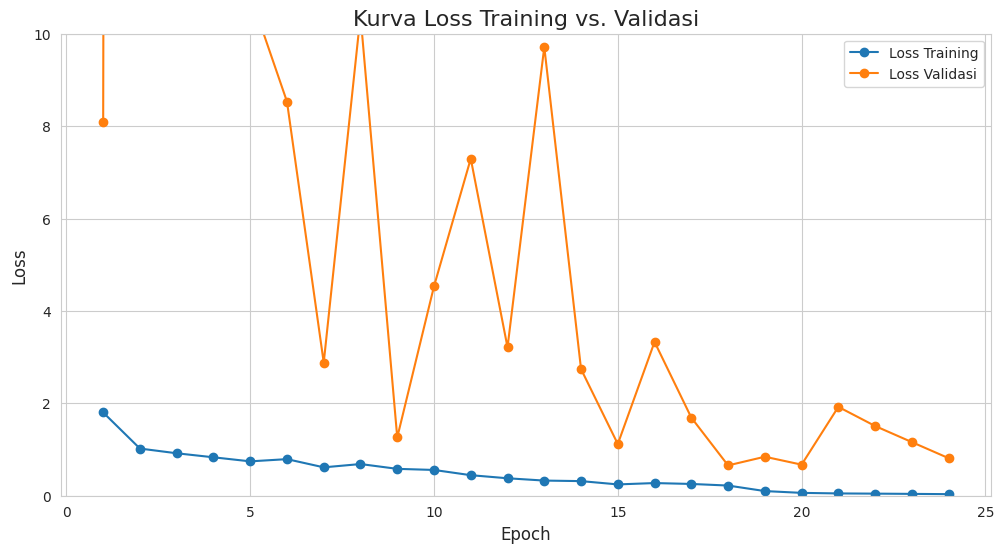

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Menggunakan style dari seaborn agar grafik lebih menarik
sns.set_style("whitegrid")

# Pastikan 'history' sudah ada dari training loop
df_history = pd.DataFrame(history)
df_history['epoch'] = df_history.index + 1

# ===================================================================
# 1. Plot Grafik Akurasi
# ===================================================================
plt.figure(figsize=(12, 6))
plt.plot(df_history['epoch'], df_history['train_acc'], marker='o', label='Akurasi Training')
plt.plot(df_history['epoch'], df_history['val_acc'], marker='o', label='Akurasi Validasi')
plt.title('Kurva Akurasi Training vs. Validasi', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend()
plt.show()

# ===================================================================
# 2. Plot Grafik Loss
# ===================================================================
plt.figure(figsize=(12, 6))
plt.plot(df_history['epoch'], df_history['train_loss'], marker='o', label='Loss Training')
plt.plot(df_history['epoch'], df_history['val_loss'], marker='o', label='Loss Validasi')
plt.ylim(0, 10) 
plt.title('Kurva Loss Training vs. Validasi', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

In [30]:
# Pastikan 'model' adalah variabel yang berisi model terbaik Anda
# dan 'save_path' adalah nama file yang Anda inginkan
save_path = "best_model.pth"
torch.save(model.state_dict(), save_path)

print(f"✅ Model berhasil disimpan di: {save_path}")

✅ Model berhasil disimpan di: best_model.pth


In [31]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

# Pastikan 'model' adalah variabel yang berisi arsitektur Anda
# dan 'device' sudah terdefinisi

# Muat bobot terbaik yang sudah Anda simpan
model.load_state_dict(torch.load('best_model.pth'))
model.eval() # Set ke mode evaluasi

# Lacak model untuk mengonversinya ke TorchScript
example_input = torch.rand(1, 3, 224, 224).to(device) 
traced_script_module = torch.jit.trace(model, example_input)

# Optimalkan untuk mobile
optimized_traced_module = optimize_for_mobile(traced_script_module)

# Simpan model dalam format .ptl
optimized_traced_module.save("model_mobile.ptl")

print("✅ Model berhasil dikonversi ke 'model_mobile.ptl'.")

✅ Model berhasil dikonversi ke 'model_mobile.ptl'.


In [34]:
import torch

# Pastikan 'model' dan 'device' sudah ada

# Muat bobot model terbaik
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Buat contoh input (dummy tensor)
dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
onnx_path = "/kaggle/working/model.onnx"

print(f"Mengekspor model ke format ONNX di {onnx_path}...")
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    # --- PERBAIKAN DI SINI ---
    opset_version=16, # Naikkan versi opset ke yang lebih baru
    # -------------------------
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input' : {0 : 'batch_size'},
                  'output' : {0 : 'batch_size'}}
)
print("✅ Model berhasil diekspor ke format ONNX.")

Mengekspor model ke format ONNX di /kaggle/working/model.onnx...
✅ Model berhasil diekspor ke format ONNX.
